In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [78]:
df = pd.read_csv("D:/Data Science/Datasets for Capstone Projects-20240907T072954Z-001/house-prices-advanced-regression-techniques/train.csv")

In [79]:
df.shape #Data size

(1460, 81)

In [80]:
df.head()           #first 5 rows

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [82]:
numeric_features = df.select_dtypes(include=["int64" , "float64"]).columns #checking for numerical columns 
len(numeric_features)

38

In [83]:
categorical_features = df.select_dtypes(include=["object"]).columns     #checking for categorical columns  
len(categorical_features)

43

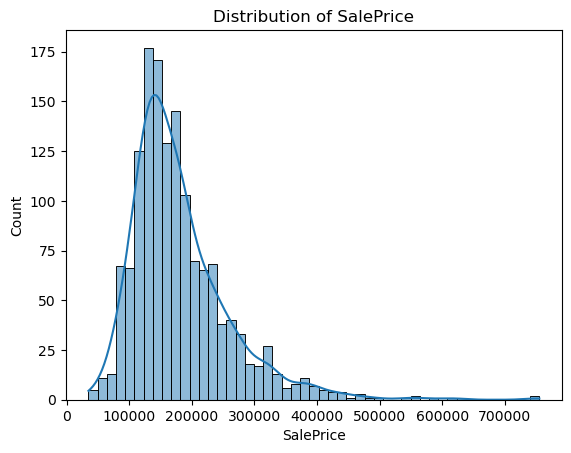

In [84]:
sns.histplot(df["SalePrice"], kde=True) #Target Distribution SalePrice
plt.title("Distribution of SalePrice")
plt.show()

In [85]:
missing = df.isnull().sum().sort_values(ascending = False) #Missing Values
missing = missing[missing > 0 ] #Only columns with missing values
missing.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [93]:
numeric_features = df.select_dtypes(include=["int64" , "float64"])
corr = numeric_features.corr()["SalePrice"].sort_values(ascending=False) # Correlation with SalePrice

print("Top 10 Features Related to Price:\n", corr.head(10))
print("\nLast 10 Features Related to Price:\n", corr.tail(10))

Top 10 Features Related to Price:
 SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

Last 10 Features Related to Price:
 BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


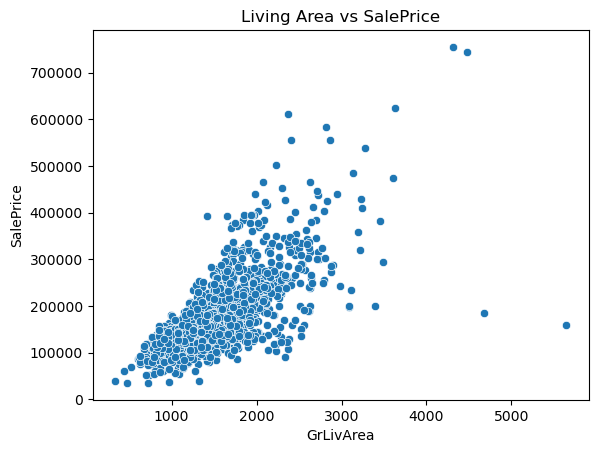

In [95]:
sns.scatterplot(x=df["GrLivArea"], y=df["SalePrice"])
plt.title("Living Area vs SalePrice")
plt.show()

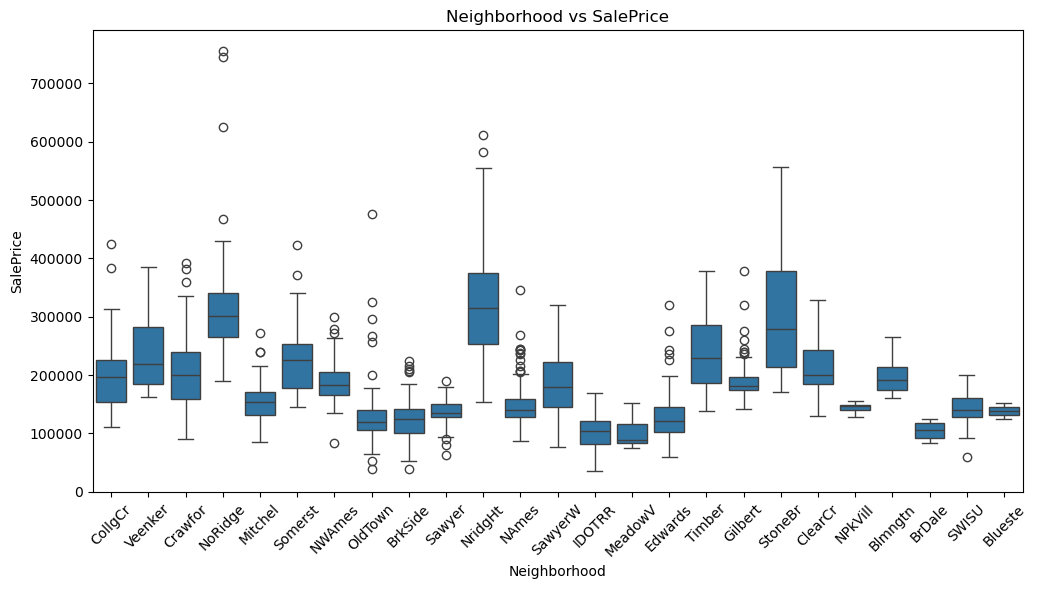

In [97]:
plt.figure(figsize=(12,6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=df)
plt.xticks(rotation=45)
plt.title("Neighborhood vs SalePrice")
plt.show()

In [99]:
# We determine the threshold: any column with more than 40% missing → we delete it
threshold = 0.4 * len(train)

# The columns that we will erase
cols_to_drop = df.columns[df.isnull().sum() > threshold]
df = df.drop(columns=cols_to_drop)

print("The columns that were removed:", cols_to_drop.tolist())

The columns that were removed: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [111]:
#treating the missing value with median for numericals and mode for categorical
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Number of missing values after cleaning:", df.isnull().sum().sum())

Number of missing values after cleaning: 0


In [113]:
train.isnull().sum().sum()

0

In [117]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)

print("Shape after Encoding:", df_encoded.shape)

Shape after Encoding: (1460, 231)


In [119]:
X = df_encoded.drop("SalePrice", axis=1)  #Independent variables
y = df_encoded["SalePrice"]              #Target

In [125]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [131]:
#Create the model
model = LinearRegression()

#Data training
model.fit(x_train, y_train)

#Prediction on test
y_pred = model.predict(x_test)

#Performance evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 51992.04644679972
R² Score: 0.6475804521594797


In [135]:
#Create the model
rf_model = RandomForestRegressor(
    n_estimators=200,   #Number of trees
    max_depth=None,     #Depth (you can try different values)
    random_state=42,
    n_jobs=-1           #Uses all processors to speed up training.
)

#train
rf_model.fit(x_train, y_train)

#Prediction
y_pred_rf = rf_model.predict(x_test)

#evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R² Score:", r2_rf)

Random Forest RMSE: 28647.752824472474
Random Forest R² Score: 0.893004062705563


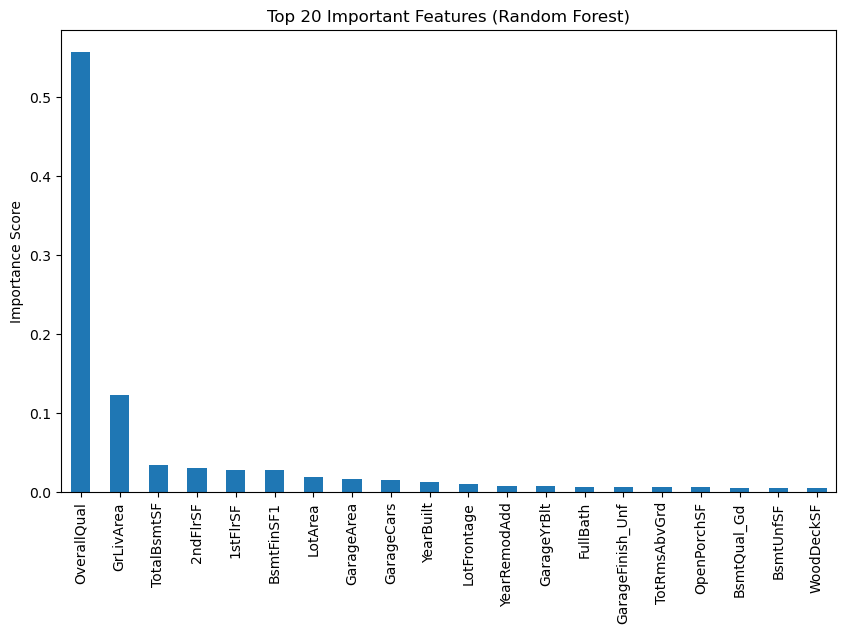

In [137]:
#Calculate Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=x_train.columns)

#Sort and select the top 20 features
top_features = feature_importances.sort_values(ascending=False).head(20)

# Bar Plot Drawing
plt.figure(figsize=(10,6))
top_features.plot(kind='bar')
plt.title("Top 20 Important Features (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

In [141]:
#Create the model
xgb_model = XGBRegressor(
    n_estimators=500,     # عدد الأشجار
    learning_rate=0.05,   # معدل التعلم
    max_depth=4,          # العمق
    random_state=42,
    n_jobs=-1
)

#Train
xgb_model.fit(x_train, y_train)

#Prediction
y_pred_xgb = xgb_model.predict(x_test)

#evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R² Score:", r2_xgb)

XGBoost RMSE: 26279.070889523297
XGBoost R² Score: 0.9099660515785217


In [143]:
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [51992.04, 28647.75, 26279.07],
    "R² Score": [0.648, 0.893, 0.910]
}
results_df = pd.DataFrame(results)

print(results_df)

               Model      RMSE  R² Score
0  Linear Regression  51992.04     0.648
1      Random Forest  28647.75     0.893
2            XGBoost  26279.07     0.910
